### Импорт
В этом проекте мы будем использовать стандартные библиотеки науки о данных и машинного обучения.

In [185]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer


# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Считывание данных
Сначала давайте прочитаем отформатированные данные из предыдущей записной книжки.

In [186]:
train_features = pd.read_csv('data/features_train.csv')
test_features = pd.read_csv('data/features_test.csv')
target = pd.read_csv('data/target.csv')


# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training target Size:  ', target.shape)


Training Feature Size:  (1460, 234)
Testing Feature Size:   (1459, 234)
Training target Size:   (1460, 1)


In [187]:
train_features = train_features.drop(['SalePrice'], axis = 1)
test_features = test_features.drop(['SalePrice'], axis = 1)

In [188]:
test_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),...,GarageFinish_RFn,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,PavedDrive_N,PavedDrive_P,PoolQC_Ex,PoolQC_Fa,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,0.0,2,1,0,730.0,140,0,0,0,120,0,0,6,2010,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,0.0,3,1,0,312.0,393,36,0,0,0,0,12500,6,2010,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,0.0,3,1,1,482.0,212,34,0,0,0,0,0,3,2010,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,0.0,3,1,1,470.0,360,36,0,0,0,0,0,6,2010,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,0.0,2,1,0,506.0,0,82,0,0,144,0,0,1,2010,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [189]:
target.tail()

,SalePrice
1455,175000
1456,210000
1457,266500
1458,142125
1459,147500


In [190]:
dataset_features =  pd.concat(objs=[train_features, test_features], axis=0).reset_index(drop=True)

In [191]:
# функция поиска недостающих данных
def find_missing_data(data):
    Total = data.isnull().sum().sort_values(ascending = False)
    Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    
    return pd.concat([Total, Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

In [192]:
find_missing_data(dataset_features).head(10)

,Total,Percent
LotFrontage,486,0.166495
MasVnrArea,23,0.007879
BsmtHalfBath,2,0.000685
BsmtUnfSF,1,0.000343
GarageArea,1,0.000343
BsmtFinSF1,1,0.000343
BsmtFinSF2,1,0.000343
TotalBsmtSF,1,0.000343
BsmtExposure_Mn,0,0.000000
BsmtFinType1_GLQ,0,0.000000


## Замена Пропущенных Значений

In [193]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [194]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


##  нормализация данных

In [195]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test0 = scaler.transform(X_test)

In [196]:
from sklearn.model_selection import train_test_split

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(X, target, test_size = 0.3, random_state = 42)

In [197]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(1022, 233)
(438, 233)
(1022, 1)
(438, 1)


In [198]:
# Convert y to one-dimensional array (vector) Преобразовать y в одномерный массив (вектор)
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))


In [199]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [200]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))
print('min', y.min(),'max',y.max())


The baseline guess is a score of 165000.00
Baseline Performance on the test set: MAE = 57047.0046
min 34900 max 745000


##  Models to Evaluate

In [201]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [202]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 60795926307092.5547


In [203]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 42985.8968


In [204]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 18746.5716


In [205]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 17366.3228


In [206]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 26655.1705


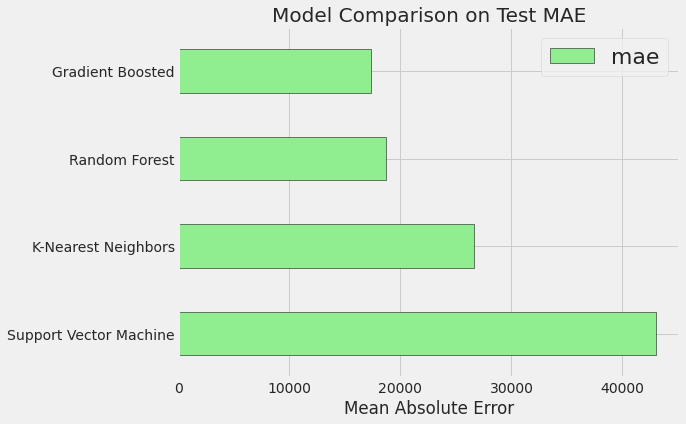

In [207]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [ svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'lightgreen', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

### Hyperparameter Tuning with Random Search and Cross Validation

In [208]:
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Minimum number of samples per leaf
min_samples_leaf = [2, 3, 4, 5, 6, 7, 8,]

# Minimum number of samples to split a node
min_samples_split = [2, 3, 4, 5, 6, 7, 8,]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [209]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [210]:
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


RandomizedSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_

In [211]:
random_cv.best_estimator_

GradientBoostingRegressor(loss='huber', max_depth=5, max_features='sqrt',
                          min_samples_leaf=5, min_samples_split=3,
                          n_estimators=1500, random_state=42)

In [212]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]}

model = GradientBoostingRegressor(loss = 'huber', max_depth = 5,
                                  min_samples_leaf = 5,
                                  min_samples_split = 3,
                                  max_features = 'sqrt',
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [213]:
grid_search.fit(X, y)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(loss='huber', max_depth=5,
                                                 max_features='sqrt',
                                                 min_samples_leaf=5,
                                                 min_samples_split=3,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [300, 350, 400, 450, 500, 550, 600,
                                          650, 700, 750, 800, 850, 900, 1000,
                                          1100, 1200, 1300, 1400, 1500, 1600,
                                          1700, 1800, 1900, 2000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [214]:
grid_search.best_estimator_

GradientBoostingRegressor(loss='huber', max_depth=5, max_features='sqrt',
                          min_samples_leaf=5, min_samples_split=3,
                          n_estimators=550, random_state=42)

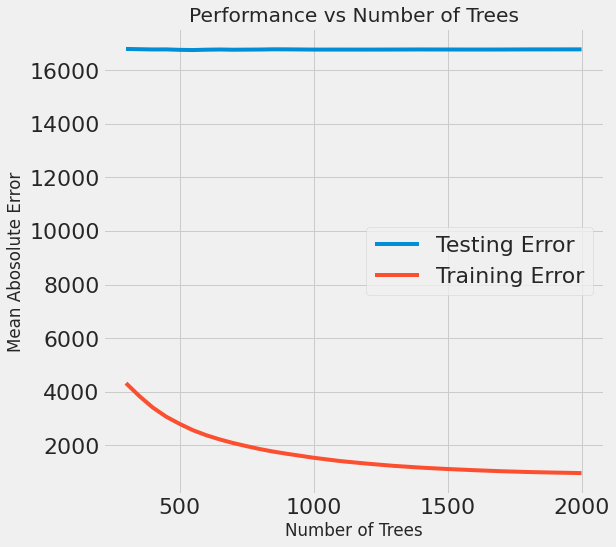

In [215]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [216]:
ID = pd.read_csv('data/test.csv')
ID = ID.Id
ID

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [218]:
Predictive_Model = pd.DataFrame({
        "Id": ID,
        "SAlePrice": grid_search.predict(X_test0)})

Predictive_Model.to_csv('number_11.csv', index=False)